## Cargado Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, precision_score, confusion_matrix,accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder,StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd



# Custom DropColumn
from sklearn.base import BaseEstimator, TransformerMixin


import pandas as pd
import seaborn as sns

df = pd.read_csv('churn-bigml-80.csv')

class DropColumn(BaseEstimator, TransformerMixin):
    def __init__(self, cols=[]):
        self.cols = cols
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.drop(self.cols, axis=1)

# Función para graficar matriz de confusión
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Clase 0', 'Clase 1'],
                yticklabels=['Clase 0', 'Clase 1'])
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title(title)
    plt.tight_layout()
    plt.show()

from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class AddSumOfColumnsColumn(BaseEstimator, TransformerMixin):
    def __init__(self, columns, constant=0, name='AddedColumns'):
        self.columns = columns
        self.constant = constant
        self.name = name

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        added_series = X_copy[self.columns].sum(axis=1) + self.constant
        added_series.name = self.name
        return pd.concat([X_copy, added_series], axis=1)

class OutlierReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, method='iqr'):
        self.columns = columns
        self.method = method
        self.medians_ = {}

    def fit(self, X, y=None):
        X_ = X.copy()
        if self.columns is None:
            self.columns = X_.select_dtypes(include=np.number).columns.tolist()
        for col in self.columns:
            self.medians_[col] = X_[col].median()
        return self

    def transform(self, X):
        X_ = X.copy()
        for col in self.columns:
            if self.method == 'iqr':
                Q1 = X_[col].quantile(0.25)
                Q3 = X_[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                # Reemplazar por la mediana si está fuera de los límites
                median = self.medians_[col]
                X_.loc[(X_[col] < lower_bound) | (X_[col] > upper_bound), col] = median
        return X_

# Business Value
def calcular_business_value(conf_matrix_df, clientes_estimados=1200, anios=5):
    tn = conf_matrix_df.loc["Actual No Churn", "Predicted No Churn"]
    fp = conf_matrix_df.loc["Actual No Churn", "Predicted Churn"]
    fn = conf_matrix_df.loc["Actual Churn", "Predicted No Churn"]
    tp = conf_matrix_df.loc["Actual Churn", "Predicted Churn"]

    clientes_estimados_n = clientes_estimados * anios

    ganancia_tn = clientes_estimados_n * tn
    perdida_fp = -0.2 * fp * clientes_estimados_n
    perdida_fn = -clientes_estimados_n * fn
    costo_tp = -0.2 * tp * clientes_estimados_n

    total_neto = ganancia_tn + perdida_fp + perdida_fn + costo_tp

    return {
        "ganancia_tn": ganancia_tn,
        "perdida_fp": perdida_fp,
        "perdida_fn": perdida_fn,
        "costo_tp": costo_tp,
        "total_neto": total_neto
    }

def plot_confusion_matrix(cm, title='Matriz de Confusión', labels=['No Churn', 'Churn']):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=[f'Pred {l}' for l in labels],
                yticklabels=[f'Real {l}' for l in labels])
    plt.title(title)
    plt.ylabel('Valor real')
    plt.xlabel('Predicción')
    plt.tight_layout()
    plt.show()

In [2]:
# 2. Target como entero si es booleano
y = df['Churn'].astype(int)
X = df.drop(columns=['Churn'])

In [3]:
# Definir las variables por tipo
categoricas = ['State', 'International plan', 'Voice mail plan']
enteras = [
    'Account length', 'Area code', 'Number vmail messages',
    'Total day calls', 'Total eve calls', 'Total night calls',
    'Total intl calls', 'Customer service calls'
]
continuas = [
    'Total day minutes', 'Total day charge',
    'Total eve minutes', 'Total eve charge',
    'Total night minutes', 'Total night charge',
    'Total intl minutes', 'Total intl charge'
]

# Asignar tipos
for col in categoricas:
    df[col] = df[col].astype('category')

for col in enteras:
    df[col] = df[col].astype('int64')

for col in continuas:
    df[col] = df[col].astype('float64')

df['Churn'] = df['Churn'].astype(bool)

## Hipotesis Inicial

In [4]:
# Separar las características y la variable objetivo
X = df.drop(columns=['Churn'])
y = df['Churn']

# Identificar las columnas categóricas y numéricas
categorical_cols = ['State', 'International plan', 'Voice mail plan']
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Crear transformadores para las columnas categóricas y numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ],
    sparse_threshold=0  # Asegurar que la salida sea densa
)

# Crear un pipeline que incluya el preprocesador y el clasificador
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])

# Dividir los datos en conjuntos de entrenamiento (70%) y prueba (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Realizar la validación cruzada de 10 pliegues
kf = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=kf)

# Entrenar el clasificador en el conjunto de entrenamiento completo
pipeline.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = pipeline.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)

# Generar el informe de clasificación
classification_metrics = classification_report(y_test, y_pred)

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Etiquetar las filas y columnas de la matriz de confusión
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual No Churn', 'Actual Churn'], columns=['Predicted No Churn', 'Predicted Churn'])

print(f"Precisión del clasificador Naive Bayes: {accuracy * 100:.2f}%")
print(f"Puntuaciones de validación cruzada de 10 pliegues: {cv_scores}")
print(f"Puntuación media de validación cruzada: {cv_scores.mean() * 100:.2f}%")
print("Informe de clasificación:")
print(classification_metrics)
print("Matriz de confusión etiquetada:")
print(conf_matrix_df)

resultado = calcular_business_value(conf_matrix_df)

Precisión del clasificador Naive Bayes: 54.50%
Puntuaciones de validación cruzada de 10 pliegues: [0.55614973 0.4973262  0.56684492 0.49197861 0.45989305 0.5828877
 0.46774194 0.55376344 0.56989247 0.48387097]
Puntuación media de validación cruzada: 52.30%
Informe de clasificación:
              precision    recall  f1-score   support

       False       0.88      0.54      0.67       683
        True       0.17      0.56      0.27       117

    accuracy                           0.55       800
   macro avg       0.53      0.55      0.47       800
weighted avg       0.78      0.55      0.61       800

Matriz de confusión etiquetada:
                 Predicted No Churn  Predicted Churn
Actual No Churn                 370              313
Actual Churn                     51               66


## Exploracion de H6

### Hipotesis Inicial

In [6]:
# Copiar base para H6
H6 = df.copy()

# Crear nueva columna Total charge sumando los tres cargos
H6["Total charge"] = (
    H6["Total day charge"] +
    H6["Total eve charge"] +
    H6["Total night charge"]
)

# Eliminar columnas originales si ya no se necesitan
H6.drop(columns=["Total day charge", "Total eve charge", "Total night charge"], inplace=True)

H6_encoded = pd.get_dummies(H6.drop(columns=['Churn']), drop_first=True)

# 2. Target como entero si es booleano
y_h6 = H6['Churn'].astype(int)
X_h6 = H6_encoded

X_h6_train, X_h6_test, y_h6_train, y_h6_test = train_test_split(X_h6, y_h6, test_size=0.3, random_state=42)

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

# Definir el modelo base
h6_rf_base = RandomForestClassifier(random_state=42)

# Espacio de búsqueda de hiperparámetros
param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(5, 7),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2',None]
}

# Randomized search con validación cruzada
h6_random_search = RandomizedSearchCV(
    h6_rf_base,
    param_distributions=param_dist,
    n_iter=25,
    cv=3,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

# Entrenar
h6_random_search.fit(X_h6_train, y_h6_train)

# Mejor modelo
best_rf_h6 = h6_random_search.best_estimator_
print("🔧 Mejores hiperparámetros encontrados:")
print(h6_random_search.best_params_)

# Aplicar 10-fold cross-validation
cv_scores = cross_val_score(best_rf_h6, X_h6, y_h6, cv=10, scoring='precision')

# Resultados
print("📈 Puntuaciones de cada fold (10-fold CV):")
print(cv_scores)

print(f"\n📊 Precisión promedio: {cv_scores.mean() * 100:.2f}%")
print(f"📉 Desviación estándar: {cv_scores.std() * 100:.2f}%")

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score

# Predicción
rf_h6_y_train_pred = best_rf_h6.predict(X_h6_train)

# Precisión (positiva, clase 1
pres = precision_score(y_h6_train, rf_h6_y_train_pred)

print(f"\n📊 Precisión (positive class) en train: {pres:.2%}")
print("🧾 Informe de clasificación:")
print(classification_report(y_h6_train, rf_h6_y_train_pred))

# Predicción
rf_h6_y_test_pred = best_rf_h6.predict(X_h6_test)

# Precisión (positiva, clase 1
pres = precision_score(y_h6_test, rf_h6_y_test_pred)

print(f"\n📊 Precisión (positive class) en test: {pres:.2%}")
print("🧾 Informe de clasificación:")
print(classification_report(y_h6_test, rf_h6_y_test_pred))

🔧 Mejores hiperparámetros encontrados:
{'max_depth': 6, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 15, 'n_estimators': 289}
📈 Puntuaciones de cada fold (10-fold CV):
[0.9375     0.97058824 1.         1.         1.         0.94594595
 0.96666667 0.96774194 1.         1.        ]

📊 Precisión promedio: 97.88%
📉 Desviación estándar: 2.32%

📊 Precisión (positive class) en train: 98.28%
🧾 Informe de clasificación:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1595
           1       0.98      0.84      0.91       271

    accuracy                           0.97      1866
   macro avg       0.98      0.92      0.95      1866
weighted avg       0.98      0.97      0.97      1866


📊 Precisión (positive class) en test: 100.00%
🧾 Informe de clasificación:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       683
           1       1.00      0.74      0.85       117

In [7]:
# Resultados finales
h6_conf_matrix = confusion_matrix(y_h6_test, rf_h6_y_test_pred)
h6_conf_matrix_df = pd.DataFrame(h6_conf_matrix, index=['Actual No Churn', 'Actual Churn'], columns=['Predicted No Churn', 'Predicted Churn'])


h6_resultado = calcular_business_value(h6_conf_matrix_df)

# Comparación de ganancia neta
ganancia_h0 = resultado["total_neto"]
ganancia_h6 = h6_resultado["total_neto"]
mejora_ganancia_pct = ((ganancia_h6 - ganancia_h0) / abs(ganancia_h0)) * 100

# Comparación de pérdida total usando valores absolutos
perdida_h0 = resultado["perdida_fp"] + resultado["perdida_fn"] + resultado["costo_tp"]
perdida_h6 = h6_resultado["perdida_fp"] + h6_resultado["perdida_fn"] + h6_resultado["costo_tp"]

# Calcular reducción real como comparación de pérdidas absolutas
reduccion_perdida_pct = ((abs(perdida_h0) - abs(perdida_h6)) / abs(perdida_h0)) * 100

# Si pérdida nueva es mayor que la anterior, invertir signo
if abs(perdida_h6) > abs(perdida_h0):
    reduccion_perdida_pct *= -1

print(f"Mejora en ganancia neta: {mejora_ganancia_pct:.2f}% - Ganancia h0: {ganancia_h0} - Nueva Ganancia: {ganancia_h6}")
print(f"Reducción en pérdida total: {reduccion_perdida_pct:.2f}% - Pérdida h0: {perdida_h0} - Nueva Pérdida: {perdida_h6}")

Mejora en ganancia neta: 161.02% - Ganancia h0: 1459200.0 - Nueva Ganancia: 3808800.0
Reducción en pérdida total: 61.99% - Pérdida h0: -760800.0 - Nueva Pérdida: -289200.0


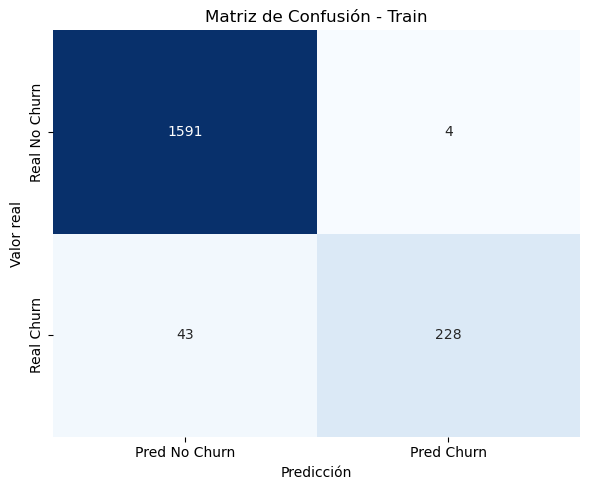

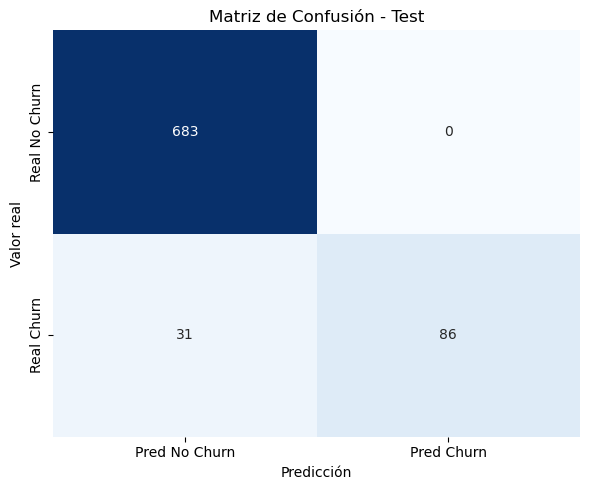

In [8]:
# 🔵 Matriz de confusión en TRAIN
h6_conf_matrix_train = confusion_matrix(y_h6_train, rf_h6_y_train_pred)
plot_confusion_matrix(h6_conf_matrix_train, title="Matriz de Confusión - Train")

# 🟢 Matriz de confusión en TEST (ya la habías generado como h6_conf_matrix)
plot_confusion_matrix(h6_conf_matrix, title="Matriz de Confusión - Test")

In [9]:
from sklearn.metrics import f1_score

# Calcular F1-score para train y test
f1_train_h6 = f1_score(y_h6_train, rf_h6_y_train_pred)
f1_test_h6 = f1_score(y_h6_test, rf_h6_y_test_pred)

# Diccionario resumen para H6
resultados_f1 = {
    'H6': {
        'F1 Train': f1_train_h6,
        'F1 Test': f1_test_h6
    }
}

### Ramas

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
columnas_sin_importancia_h6=['State','Area code','Total day calls', 'Total eve calls', 'Total night calls']

In [12]:
columnas_alta_correlacion_h6=['Total intl minutes','Total night minutes','Total eve minutes','Total day minutes']

🔧 Mejores hiperparámetros encontrados:
{'rf_model__max_depth': 6, 'rf_model__max_features': 'log2', 'rf_model__min_samples_leaf': 6, 'rf_model__min_samples_split': 11, 'rf_model__n_estimators': 103}

📊 Precisión en Train: 0.9914163090128756
🧾 Classification Report (Train):
               precision    recall  f1-score   support

       False       0.98      1.00      0.99      1595
        True       0.99      0.85      0.92       271

    accuracy                           0.98      1866
   macro avg       0.98      0.93      0.95      1866
weighted avg       0.98      0.98      0.98      1866



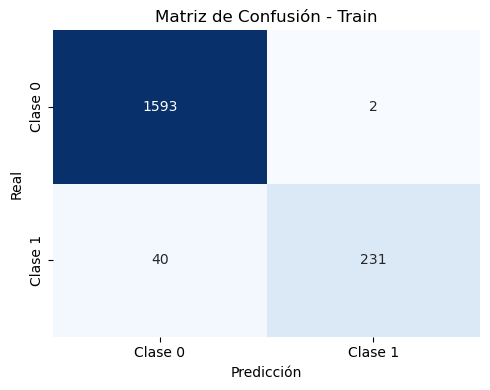


📊 Precisión en Test: 1.0
🧾 Classification Report (Test):
               precision    recall  f1-score   support

       False       0.96      1.00      0.98       683
        True       1.00      0.76      0.86       117

    accuracy                           0.96       800
   macro avg       0.98      0.88      0.92       800
weighted avg       0.97      0.96      0.96       800



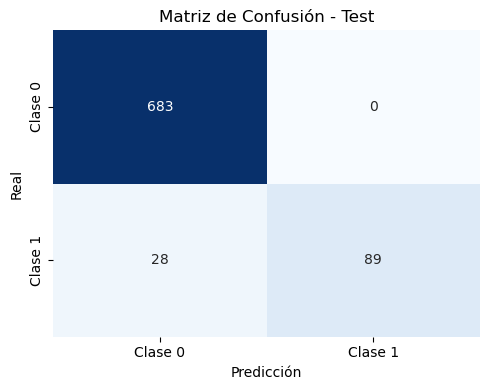

In [13]:
class AddSumOfColumnsColumn(BaseEstimator, TransformerMixin):
    def __init__(self, columns, constant=0, name='AddedColumns'):
        self.columns = columns
        self.constant = constant
        self.name = name

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        added_series = X_copy[self.columns].sum(axis=1) + self.constant
        added_series.name = self.name
        return pd.concat([X_copy, added_series], axis=1)

class OutlierReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, method='iqr'):
        self.columns = columns
        self.method = method
        self.medians_ = {}

    def fit(self, X, y=None):
        X_ = X.copy()
        if self.columns is None:
            self.columns = X_.select_dtypes(include=np.number).columns.tolist()
        for col in self.columns:
            self.medians_[col] = X_[col].median()
        return self

    def transform(self, X):
        X_ = X.copy()
        for col in self.columns:
            if self.method == 'iqr':
                Q1 = X_[col].quantile(0.25)
                Q3 = X_[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                # Reemplazar por la mediana si está fuera de los límites
                median = self.medians_[col]
                X_.loc[(X_[col] < lower_bound) | (X_[col] > upper_bound), col] = median
        return X_

multicolumn_prep_h6 = Pipeline([
    ('add_total_charge', AddSumOfColumnsColumn(
        columns=['Total day charge', 'Total eve charge', 'Total night charge'],
        name='Total charge'
    )),
    ('drop1', DropColumn(cols=columnas_sin_importancia_h6)),
    ('drop2', DropColumn(cols=columnas_alta_correlacion_h6)),
    ('drop3', DropColumn(cols=['Total day charge', 'Total eve charge', 'Total night charge'])),
    ('encode', ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'),
             ['International plan', 'Voice mail plan']),
            ('scale', MinMaxScaler(), [
                'Account length',
                'Number vmail messages',
                'Total intl calls',
                'Total intl charge',
                'Customer service calls',
                'Total charge'
            ])
        ],
        remainder='passthrough'
    ))
])


# Pipeline completo
h6_pipeline = Pipeline([
    ('preprocessing', multicolumn_prep_h6),
    #('pca', PCA(n_components=4)),
    ('rf_model', RandomForestClassifier(random_state=42))
])

# Espacio de búsqueda de hiperparámetros
param_dist = {
    'rf_model__n_estimators': randint(100, 300),
    'rf_model__max_depth': randint(5, 7),
    'rf_model__min_samples_split': randint(2, 20),
    'rf_model__min_samples_leaf': randint(1, 10),
    'rf_model__max_features': ['sqrt', 'log2', None]
}

# Randomized Search
h6_random_search = RandomizedSearchCV(
    h6_pipeline,
    param_distributions=param_dist,
    n_iter=25,
    cv=3,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

# Entrenar
h6_random_search.fit(X_train, y_train)

# Mejor pipeline entrenado
best_h6_pipeline = h6_random_search.best_estimator_

print("🔧 Mejores hiperparámetros encontrados:")
print(h6_random_search.best_params_)

# === EVALUACIÓN EN TRAIN ===
y_rh6_train_pred = best_h6_pipeline.predict(X_train)
print("\n📊 Precisión en Train:", precision_score(y_train, y_rh6_train_pred))
print("🧾 Classification Report (Train):\n", classification_report(y_train, y_rh6_train_pred))
plot_confusion(y_train, y_rh6_train_pred, "Matriz de Confusión - Train")

# === EVALUACIÓN EN TEST ===
y_rh6_test_pred = best_h6_pipeline.predict(X_test)
print("\n📊 Precisión en Test:", precision_score(y_test, y_rh6_test_pred))
print("🧾 Classification Report (Test):\n", classification_report(y_test, y_rh6_test_pred))
plot_confusion(y_test, y_rh6_test_pred, "Matriz de Confusión - Test")

In [14]:
from joblib import dump

dump(best_h6_pipeline, 'final_rh6.joblib')

print(f"Modelo guardado como: modelo_rh6.joblib")

Modelo guardado como: modelo_rh6.joblib


In [15]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from joblib import load
import ipywidgets as widgets
from IPython.display import display, HTML

df = pd.read_csv('churn-bigml-80.csv')


modelo = load("final_rh6.joblib")  # Cambia por tu modelo si es necesario

# Definir las variables por tipo
categoricas = ['State', 'International plan', 'Voice mail plan']
enteras = [
    'Account length', 'Area code', 'Number vmail messages',
    'Total day calls', 'Total eve calls', 'Total night calls',
    'Total intl calls', 'Customer service calls'
]
continuas = [
    'Total day minutes', 'Total day charge',
    'Total eve minutes', 'Total eve charge',
    'Total night minutes', 'Total night charge',
    'Total intl minutes', 'Total intl charge'
]

# Asignar tipos
for col in categoricas:
    df[col] = df[col].astype('category')

for col in enteras:
    df[col] = df[col].astype('int64')

for col in continuas:
    df[col] = df[col].astype('float64')

df['Churn'] = df['Churn'].astype(bool)

X = df.drop(columns=['Churn'])
y = df['Churn']

target_names=['True','False']

# Separar train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Seleccionar 10 muestras aleatorias
num_muestras = 10
indices_aleatorios = np.random.choice(X_test.index, size=num_muestras, replace=False)
X_muestra = X_test.loc[indices_aleatorios]
y_muestra = y_test.loc[indices_aleatorios]

# Crear DataFrame conjunto
df_muestra = X_muestra.copy()
df_muestra["Verdadero"] = [target_names[i] for i in y_muestra]
df_muestra.reset_index(drop=True, inplace=True)  # Para índice 0..9

# Dropdown para elegir una fila
dropdown = widgets.Dropdown(
    options=[(f"Fila {i}", i) for i in range(len(df_muestra))],
    description="Seleccionar fila:"
)

# Botón para clasificar
button = widgets.Button(description="Clasificar", button_style="primary")
output = widgets.Output()

# Función para pintar solo la fila seleccionada
def pintar_fila(row, fila_seleccionada, acierto):
    if row.name != fila_seleccionada:
        return [''] * len(row)
    color = 'background-color: lightgreen' if acierto else 'background-color: salmon'
    return [color] * len(row)

# Función al presionar el botón
def on_button_clicked(b):
    output.clear_output()
    fila_idx = dropdown.value
    X_row = X_muestra.iloc[[fila_idx]]
    y_true = y_muestra.iloc[fila_idx]
    y_pred = modelo.predict(X_row)[0]
    #y_pred = modelo.predict(X_row)[0]

    acierta = y_pred == y_true
    clase_verdadera = target_names[y_true]
    clase_predicha = target_names[y_pred]

    with output:
        print(f"🎯 Clase verdadera: {clase_verdadera}")
        print(f"🤖 Clase predicha: {clase_predicha}")
        print(f"{'Predecido correctamente' if acierta else 'Error'}")

        df_resultado = df_muestra.copy()
        df_resultado["Predicho"] = ""
        df_resultado.loc[fila_idx, "Predicho"] = clase_predicha

        tabla_coloreada = df_resultado.style.apply(
            pintar_fila,
            axis=1,
            fila_seleccionada=fila_idx,
            acierto=acierta
        )

        display(HTML("<h4>📊 Resultado de clasificación</h4>"))
        display(tabla_coloreada)

# Conectar botón
button.on_click(on_button_clicked)

# Mostrar todo
display(HTML("<h4>🔍 Muestras seleccionadas del conjunto de prueba:</h4>"))
display(df_muestra)
display(widgets.VBox([dropdown, button, output]))

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Verdadero
0,DE,115,408,No,No,0,127.7,67,21.71,182.9,90,15.55,172.9,92,7.78,10.6,7,2.86,1,True
1,AL,49,415,No,Yes,28,214.4,78,36.45,235.2,100,19.99,206.2,107,9.28,8.0,13,2.16,3,True
2,ID,128,408,No,No,0,125.2,99,21.28,205.4,107,17.46,254.4,111,11.45,18.9,2,5.10,0,True
3,WV,86,415,No,Yes,38,123.0,158,20.91,133.9,119,11.38,138.2,103,6.22,13.3,4,3.59,1,True
4,NY,181,408,No,No,0,143.3,91,24.36,195.5,58,16.62,223.3,95,10.05,6.0,7,1.62,1,True
5,MS,59,408,No,Yes,27,127.4,110,21.66,103.3,99,8.78,164.2,73,7.39,9.1,3,2.46,0,True
6,LA,115,415,No,Yes,26,170.5,107,28.99,217.2,77,18.46,225.7,71,10.16,13.6,5,3.67,6,True
7,MS,122,408,No,Yes,45,147.8,85,25.13,147.4,93,12.53,203.5,110,9.16,14.0,5,3.78,1,True
8,WA,45,510,No,No,0,78.6,106,13.36,187.3,110,15.92,184.2,111,8.29,7.4,5,2.00,1,False
9,FL,75,510,No,Yes,26,118.5,86,20.15,213.9,118,18.18,132.6,99,5.97,13.4,3,3.62,2,True


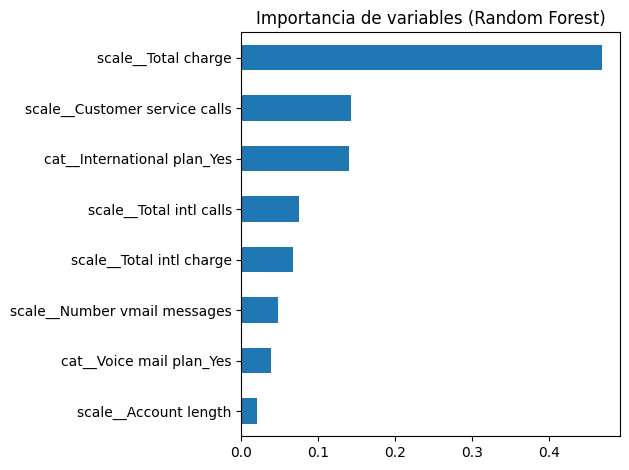

In [137]:
# Obtener el modelo RandomForest desde el pipeline
rf_model = best_h6_pipeline.named_steps['rf_model']

# Obtener el ColumnTransformer para reconstruir nombres de columnas transformadas
ct = best_h6_pipeline.named_steps['preprocessing'].named_steps['encode']

# Nombres de columnas luego del OneHotEncoder y MinMaxScaler
encoded_cols = ct.get_feature_names_out()

# Obtener importancias de características
importancias = rf_model.feature_importances_

# Crear gráfico
feat_imp = pd.Series(importancias, index=encoded_cols).sort_values(ascending=False)
feat_imp.head(15).plot(kind='barh', title='Importancia de variables (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [115]:
# Resultados finales
rh6_conf_matrix = confusion_matrix(y_test, y_rh6_test_pred)
rh6_conf_matrix_df = pd.DataFrame(rh6_conf_matrix, index=['Actual No Churn', 'Actual Churn'], columns=['Predicted No Churn', 'Predicted Churn'])


rh6_resultado = calcular_business_value(rh6_conf_matrix_df)

# Comparación de ganancia neta
ganancia_h0 = resultado["total_neto"]
ganancia_rh6 = rh6_resultado["total_neto"]
mejora_ganancia_pct = ((ganancia_rh6 - ganancia_h0) / abs(ganancia_h0)) * 100

# Comparación de pérdida total usando valores absolutos
perdida_h0 = resultado["perdida_fp"] + resultado["perdida_fn"] + resultado["costo_tp"]
perdida_rh6 = rh6_resultado["perdida_fp"] + rh6_resultado["perdida_fn"] + rh6_resultado["costo_tp"]

# Calcular reducción real como comparación de pérdidas absolutas
reduccion_perdida_pct = ((abs(perdida_h0) - abs(perdida_rh6)) / abs(perdida_h0)) * 100

# Si pérdida nueva es mayor que la anterior, invertir signo
if abs(perdida_rh6) > abs(perdida_h0):
    reduccion_perdida_pct *= -1

print(f"Mejora en ganancia neta: {mejora_ganancia_pct:.2f}% - Ganancia h0: {ganancia_h0} - Ganancia H6: {ganancia_h6} - Ganancia RH6: {ganancia_rh6}")
print(f"Reducción en pérdida total: {reduccion_perdida_pct:.2f}% - Pérdida h0: {perdida_h0} - Pérdida H6: {perdida_h6} - Pérdida RH6: {perdida_rh6}")

Mejora en ganancia neta: 162.01% - Ganancia h0: 1459200.0 - Ganancia H6: 3808800.0 - Ganancia RH6: 3823200.0
Reducción en pérdida total: 63.88% - Pérdida h0: -760800.0 - Pérdida H6: -289200.0 - Pérdida RH6: -274800.0


In [120]:
def evaluar_ganancia_perdida(ganancia_h0, ganancia_h6, ganancia_rh6,
                              perdida_h0, perdida_h6, perdida_rh6,nh):
    # Calcular mejoras porcentuales
    mejora_ganancia_pct = ((ganancia_rh6 - ganancia_h0) / ganancia_h0) * 100
    reduccion_perdida_pct = ((perdida_h0 - perdida_rh6) / abs(perdida_h0)) * 100

    # Imprimir resultados
    #print(f"🔹 Mejora en ganancia neta: {mejora_ganancia_pct:.2f}% - Ganancia h0: {ganancia_h0:,.0f} - Ganancia H6: {ganancia_h6:,.0f} - Ganancia RH6: {ganancia_rh6:,.0f}")
    #print(f"🔸 Reducción en pérdida total: {reduccion_perdida_pct:.2f}% - Pérdida h0: {perdida_h0:,.0f} - Pérdida H6: {perdida_h6:,.0f} - Pérdida RH6: {perdida_rh6:,.0f}")

    # Datos para graficar
    modelos = ['H0', f'H{nh}', f'RH{nh}']
    ganancias = [ganancia_h0, ganancia_h6, ganancia_rh6]
    perdidas = [perdida_h0, perdida_h6, perdida_rh6]

    x = np.arange(len(modelos))
    width = 0.35

    # Gráfico
    fig, ax = plt.subplots(figsize=(7, 5))
    bars1 = ax.bar(x - width/2, ganancias, width, label='Ganancia Neta', color='steelblue')
    bars2 = ax.bar(x + width/2, perdidas, width, label='Pérdida Total', color='indianred')

    ax.set_ylabel('Monto en S/.')
    #ax.set_title('Comparativo de Ganancia Neta y Pérdida Total por Modelo')
    ax.set_xticks(x)
    ax.set_xticklabels(modelos)
    ax.legend()
    ax.axhline(0, color='black', linewidth=0.8)

    for bar in bars1 + bars2:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval,
                f'{int(yval):,}', ha='center',
                va='bottom' if yval > 0 else 'top', fontsize=9)

    plt.tight_layout()
    plt.show()

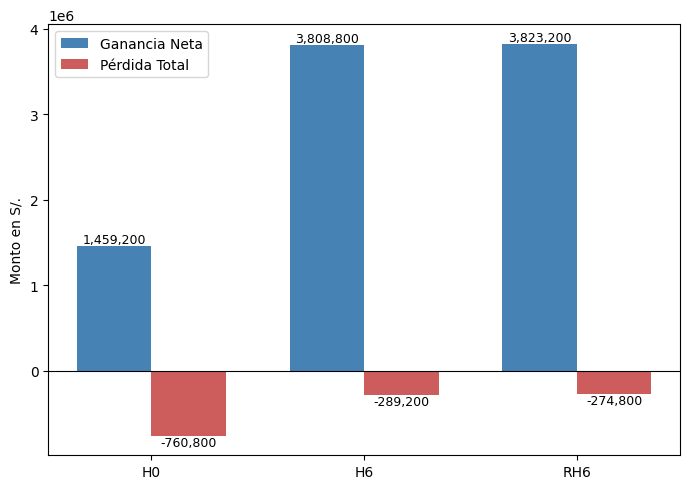

In [121]:
evaluar_ganancia_perdida(
    ganancia_h0,
    ganancia_h6,
    ganancia_rh6,
    perdida_h0,
    perdida_h6,
    perdida_rh6,
    6
)

In [128]:
# Agregar RH6 al diccionario
f1_train_rh6 = f1_score(y_train, y_rh6_train_pred)
f1_test_rh6 = f1_score(y_test, y_rh6_test_pred)
resultados_f1['RH6'] = {
    'F1 Train': f1_train_rh6,
    'F1 Test': f1_test_rh6
}

# Mostrar resumen
print("\n📊 Resultados F1-Score:")
print(pd.DataFrame(resultados_f1).T)


📊 Resultados F1-Score:
     F1 Train   F1 Test
H6   0.906561  0.847291
RH6  0.916667  0.864078


### Permutation Importance

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

In [ ]:
multicolumn_prep_pi_h6 = Pipeline([
    ('add_total_charge', AddSumOfColumnsColumn(
        columns=['Total day charge', 'Total eve charge', 'Total night charge'],
        name='Total charge'
    )),
    ('drop1', DropColumn(cols=columnas_sin_importancia_h6)),
    ('drop2', DropColumn(cols=columnas_alta_correlacion_h6)),
    ('drop3', DropColumn(cols=['Total day charge', 'Total eve charge', 'Total night charge'])),
    ('encode', ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'),
             ['International plan', 'Voice mail plan']),
            ('scale', MinMaxScaler(), [
                'Account length',
                'Number vmail messages',
                'Total intl calls',
                'Total intl charge',
                'Customer service calls',
                'Total charge'
            ])
        ],
        remainder='passthrough'
    ))
])


# Pipeline completo
pi_h6_pipeline = Pipeline([
    ('preprocessing', multicolumn_prep_pi_h6),
    #('pca', PCA(n_components=4)),
    ('rf_model', RandomForestClassifier(random_state=42))
])

pi_h6_pipeline.fit(X_train, y_train)

# Extraer modelo ya entrenado
rf_model = pi_h6_pipeline.named_steps['rf_model']

# Transformar X_test con el preprocesamiento del pipeline
X_test_transformed = pi_h6_pipeline.named_steps['preprocessing'].transform(X_test)

# Extraer nombres de features después de transformación
preprocessor = pi_h6_pipeline.named_steps['preprocessing'].named_steps['encode']
cat_features = ['International plan', 'Voice mail plan']
encoded_cat_names = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_features)

num_features = [
    'Account length', 'Number vmail messages', 'Total intl calls',
    'Total intl charge', 'Customer service calls', 'Total charge'
]

# Resto de columnas (passthrough) — si tienes identificadas
passthrough_features = preprocessor.remainder  # puede ser 'passthrough' o una lista si la defines

# Final list
all_feature_names = list(encoded_cat_names) + num_features  # + passthrough_features si las sabes

# Permutation Importance
result = permutation_importance(
    rf_model, X_test_transformed, y_test,
    n_repeats=30,
    random_state=42,
    scoring='f1'
)

# Crear DataFrame con importancias
importances_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=True)

# Graficar
plt.figure(figsize=(10, 8))
plt.errorbar(
    importances_df.importance_mean,
    importances_df.feature,
    xerr=importances_df.importance_std,
    fmt='o',
    color='blue',
    ecolor='lightblue',
    elinewidth=3,
    capsize=5
)
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('Decrease in accuracy score')
plt.title('Permutation Importances (test set) - H6 Pipeline (RandomForest)')
plt.tight_layout()
plt.show()

In [ ]:
# Nuevas columnas a eliminar por baja importancia en Permutation Importance
pi_h6_columnas_sin_importancia = [
]

# Agregarlas al array existente (evitando duplicados si es necesario)
n_columnas_importancia_h6 = list(set(columnas_sin_importancia_h6 + pi_h6_columnas_sin_importancia))

grid_multicolumn_prep_h6 = Pipeline([
    ('add_total_charge', AddSumOfColumnsColumn(
        columns=['Total day charge', 'Total eve charge', 'Total night charge'],
        name='Total charge'
    )),
    ('drop1', DropColumn(cols=n_columnas_importancia_h6)),
    ('drop2', DropColumn(cols=columnas_alta_correlacion_h6)),
    ('drop3', DropColumn(cols=['Total day charge', 'Total eve charge', 'Total night charge'])),
    ('encode', ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'),
             ['International plan','Voice mail plan']),
            ('scale', MinMaxScaler(), [
                'Total intl calls',
                'Total intl charge',
                'Customer service calls',
                'Total charge','Number vmail messages','Account length'
            ])
        ],
        remainder='passthrough'
    ))
])


# Pipeline completo
grid_h6_pipeline = Pipeline([
    ('preprocessing', grid_multicolumn_prep_h6),
    #('pca', PCA(n_components=4)),
    ('rf_model', RandomForestClassifier(random_state=42))
])

grid_search_h6 = GridSearchCV(
    grid_h6_pipeline,
    param_grid={
    'rf_model__n_estimators': [90, 100, 103, 110],         # centrado en 103
    'rf_model__max_depth': [5, 6, 7],                           # rango compacto
    'rf_model__min_samples_split': [9, 10, 11, 12, 13],         # +/- 2 del óptimo
    'rf_model__min_samples_leaf': [4, 5, 6, 7, 8],              # +/- 2 del óptimo
    'rf_model__max_features': ['log2', 'sqrt']                 # mantiene log2, prueba sqrt por si acaso
    },
    scoring='f1',
    cv=10,
    n_jobs=-1,
    verbose=2
)

grid_search_h6.fit(X_train, y_train)

print("🏆 Mejor combinación de hiperparámetros encontrada:")
print(grid_search_h6.best_params_)

print(f"\n🎯 Mejor F1-score promedio (cross-validation): {grid_search_h6.best_score_:.4f}")


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# === Evaluación en TEST ===
h6_cv_y_pred_test = grid_search_h6.predict(X_test)
print("🧪 TEST SET")
print("🧾 Classification report (test):\n", classification_report(y_test, h6_cv_y_pred_test))
print("📊 Confusion matrix (test):\n", confusion_matrix(y_test, h6_cv_y_pred_test))

# === Evaluación en TRAIN ===
h6_cv_y_pred_train = grid_search_h6.predict(X_train)
print("\n🏋️ TRAINING SET")
print("🧾 Classification report (train):\n", classification_report(y_train, h6_cv_y_pred_train))
print("📊 Confusion matrix (train):\n", confusion_matrix(y_train, h6_cv_y_pred_train))

# Mejor combinación de hiperparámetros
print("✅ Best params found:\n", grid_search_h6.best_params_)

In [ ]:
# Matriz de confusión como DataFrame para análisis económico
cv_rh6_conf_matrix = confusion_matrix(y_test, h6_cv_y_pred_test)
cv_rh6_conf_matrix_df = pd.DataFrame(
    cv_rh6_conf_matrix,
    index=['Actual No Churn', 'Actual Churn'],
    columns=['Predicted No Churn', 'Predicted Churn']
)

# Calcular resultados de negocio
cv_rh6_resultado = calcular_business_value(cv_rh6_conf_matrix_df)

# === Cálculo de ganancias ===
ganancia_h0 = resultado["total_neto"]
ganancia_h6 = h6_resultado["total_neto"]
ganancia_rh6 = rh6_resultado["total_neto"]
ganancia_cv_rh6 = cv_rh6_resultado["total_neto"]

# === Cálculo de pérdidas ===
perdida_h0 = resultado["perdida_fp"] + resultado["perdida_fn"] + resultado["costo_tp"]
perdida_h6 = h6_resultado["perdida_fp"] + h6_resultado["perdida_fn"] + h6_resultado["costo_tp"]
perdida_rh6 = rh6_resultado["perdida_fp"] + rh6_resultado["perdida_fn"] + rh6_resultado["costo_tp"]
perdida_cv_rh6 = cv_rh6_resultado["perdida_fp"] + cv_rh6_resultado["perdida_fn"] + cv_rh6_resultado["costo_tp"]

# === Comparaciones relativas respecto al baseline ===
def calc_mejora(base, nuevo):
    return ((nuevo - base) / abs(base)) * 100



In [ ]:
# === Diccionario resumen ===
resumen_modelos_h6 = pd.DataFrame({
    'Modelo': ['h0 (Baseline)', 'h6', 'rh6', 'cv_rh6'],
    'Ganancia Neta': [ganancia_h0, ganancia_h6, ganancia_rh6, ganancia_cv_rh6],
    'Pérdida Total': [perdida_h0, perdida_h6, perdida_rh6, perdida_cv_rh6],
    'Mejora Ganancia %': [
        0,
        calc_mejora(ganancia_h0, ganancia_h6),
        calc_mejora(ganancia_h0, ganancia_rh6),
        calc_mejora(ganancia_h0, ganancia_cv_rh6)
    ],
    'Reducción Pérdida %': [
        0,
        calc_mejora(perdida_h0, perdida_h6) * -1,
        calc_mejora(perdida_h0, perdida_rh6) * -1,
        calc_mejora(perdida_h0, perdida_cv_rh6) * -1
    ]
})

print(resumen_modelos_h6.to_string(index=False))

In [ ]:
# === Gráfico de barras agrupadas ===
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = range(len(resumen_modelos_h6))

# Barras de Ganancia Neta y Pérdida Total
ax.bar(index, resumen_modelos_h6['Ganancia Neta'], bar_width, label='Ganancia Neta', color='orange')
ax.bar([i + bar_width for i in index], resumen_modelos_h6['Pérdida Total'], bar_width, label='Pérdida Total', color='tomato')

# Ejes y etiquetas
ax.set_xlabel('Modelo')
ax.set_ylabel('Monto')
ax.set_title('Comparación de Ganancia Neta y Pérdida Total por Modelo')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(resumen_modelos_h6['Modelo'])
ax.legend()

plt.tight_layout()
plt.show()